## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from CSV
df = pd.read_csv('data/CollegeMsgClustered.csv')

In [3]:
def bucket_to_snapshot(bucket_df):
    # Combining src and dst to generate unique node set
    nodes_df = bucket_df[['src_id', 'src_cluster']].rename(columns={'src_id': 'id', 'src_cluster': 'cluster'})
    nodes_df = nodes_df.append(bucket_df[['dst_id', 'dst_cluster']].rename(columns={'dst_id': 'id', 'dst_cluster': 'cluster'}))
    nodes_df = nodes_df.drop_duplicates()
    
    # Mapping each unique node to a unique index
    node_indices = {node_id: idx for idx, node_id in enumerate(nodes_df['id'].unique())}
    
    # Edge indices based on the newly mapped indices
    edge_index = np.array(list(zip(bucket_df["src_id"].map(node_indices), bucket_df["dst_id"].map(node_indices)))).T

    # Generate node features based on clusters
    node_features = nodes_df[['cluster']].to_numpy(dtype=np.float32)
    
    targets = nodes_df['cluster'].to_numpy(dtype=np.float32)

    edge_weight = np.ones(edge_index.shape[1], dtype=np.float32)
    
    return edge_index, node_features, edge_weight, targets

In [4]:
snapshots = []
for bucket_id in df["bucket_id"].unique():
    edge_index, node_features, edge_weight , targets= bucket_to_snapshot(df[df["bucket_id"] == bucket_id])
    snapshots.append((edge_index, node_features, edge_weight, targets))

In [5]:
# Convert snapshots to StaticGraphTemporalSignal
edge_indices = [np.array(s[0]) for s in snapshots]
node_features = [np.array(s[1]) for s in snapshots]
edge_weights = [np.array(s[2]) for s in snapshots]
targets = [np.array(s[3]) for s in snapshots]

In [6]:
for i, idx in enumerate(node_features):
    print(f"x={node_features[i].shape},edge_index={edge_indices[i].shape}, edge_weight="
          f"{edge_weights[i].shape}, targets={targets[i].shape}")

x=(5, 1),edge_index=(2, 3), edge_weight=(3,), targets=(5,)
x=(29, 1),edge_index=(2, 23), edge_weight=(23,), targets=(29,)
x=(37, 1),edge_index=(2, 28), edge_weight=(28,), targets=(37,)
x=(43, 1),edge_index=(2, 37), edge_weight=(37,), targets=(43,)
x=(62, 1),edge_index=(2, 60), edge_weight=(60,), targets=(62,)
x=(91, 1),edge_index=(2, 125), edge_weight=(125,), targets=(91,)
x=(85, 1),edge_index=(2, 124), edge_weight=(124,), targets=(85,)
x=(95, 1),edge_index=(2, 145), edge_weight=(145,), targets=(95,)
x=(107, 1),edge_index=(2, 169), edge_weight=(169,), targets=(107,)
x=(107, 1),edge_index=(2, 183), edge_weight=(183,), targets=(107,)


In [7]:
from torch_geometric_temporal import DynamicGraphTemporalSignal

dataset = DynamicGraphTemporalSignal(edge_indices=edge_indices, edge_weights=edge_weights, features=node_features, targets=targets)

In [8]:
from torch_geometric_temporal.signal import temporal_signal_split

# Split the StaticGraphTemporalSignal
train_dataset, test_dataset = temporal_signal_split(dataset, 0.8)

print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))   

Number of train buckets:  8
Number of test buckets:  2


In [9]:
import torch.nn.functional as F
from torch_geometric_temporal.nn import EvolveGCNO

# 2. Model Definition
class EvolveGCNN(torch.nn.Module):
    def __init__(self, node_features, num_classes):
        super(EvolveGCNN, self).__init__()
        self.recurrent = EvolveGCNO(node_features)
        self.linear = torch.nn.Linear(node_features, num_classes)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Number of features and classes based on dataset
node_features = train_dataset.features[0].shape[1]
num_classes = 3

model = EvolveGCNN(node_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
model.train()

EvolveGCNN(
  (recurrent): EvolveGCNO(
    (recurrent_layer): GRU(1, 1)
    (conv_layer): GCNConv_Fixed_W(1, 1)
  )
  (linear): Linear(in_features=1, out_features=3, bias=True)
)

In [12]:
# for snapshot in train_dataset:
#     x = snapshot.x.to(device)  # using dot notation for accessing attributes
#     edge_index = snapshot.edge_index.to(device)
#     edge_weight = snapshot.edge_attr.to(device)  # Assuming edge_attr is edge_weight
#     y = snapshot.y.to(device)
#     
#     out = model(x, edge_index, edge_weight)
#     loss = F.cross_entropy(out,y)
#     print(loss)

In [13]:
# 3. Training Loop
losses = []
print("Running training...")
for epoch in range(200):

    total_loss = 0
    snapshot_count = 0
    for step, snapshot in enumerate(train_dataset):
        snapshot_count += 1
        optimizer.zero_grad()
        x = snapshot.x.to(device)  # using dot notation for accessing attributes
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)  # Assuming edge_attr is edge_weight
        y_to_long = snapshot.y.type(torch.LongTensor)
        y = y_to_long.to(device)

        out = model(x, edge_index, edge_weight)
        loss = loss_fn(out,y)

        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

        number_of_snapshots = step + 1
    average_loss = total_loss / snapshot_count  # Compute average loss for the epoch
    losses.append(average_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Running training...
Epoch 0, Loss: 6.4251
Epoch 10, Loss: 4.2921
Epoch 20, Loss: 3.5841
Epoch 30, Loss: 3.3204
Epoch 40, Loss: 3.1780
Epoch 50, Loss: 3.0883
Epoch 60, Loss: 3.0271
Epoch 70, Loss: 2.9830
Epoch 80, Loss: 2.9501
Epoch 90, Loss: 2.9249
Epoch 100, Loss: 2.9052
Epoch 110, Loss: 2.8895
Epoch 120, Loss: 2.8770
Epoch 130, Loss: 2.8668
Epoch 140, Loss: 2.8584
Epoch 150, Loss: 2.8515
Epoch 160, Loss: 2.8458
Epoch 170, Loss: 2.8410
Epoch 180, Loss: 2.8370
Epoch 190, Loss: 2.8337


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
total_loss = 0

all_preds = []
all_labels = []

with torch.no_grad():  # During evaluation, no gradients are computed
    for step, snapshot in enumerate(test_dataset):
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_to_long = snapshot.y.type(torch.LongTensor)
        y = y_to_long.to(device)

        # Forward pass
        out = model(x, edge_index, edge_weight)
        loss = loss_fn(out,y)
        total_loss += loss.item()
        
        # Get predictions from the maximum value
        _, predicted = torch.max(out.data, 1)

        # Total number of labels
        total += y.size(0)

        # Total correct predictions
        correct += (predicted == y).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        number_of_snapshots = step + 1
        total_loss = total_loss / number_of_snapshots
    
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    class_report = classification_report(all_labels, all_preds, labels=[0,1,2])
    confusion_matrix = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
    
# Adjusting the index from enumerate to get the count
print(f"Test loss: {total_loss:.4f}")
print(f"Accuracy of the model on test snapshots: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test loss: 1.1393
Accuracy of the model on test snapshots: 66.82%
Precision: 0.5235
Recall: 0.5174
F1 Score: 0.5115


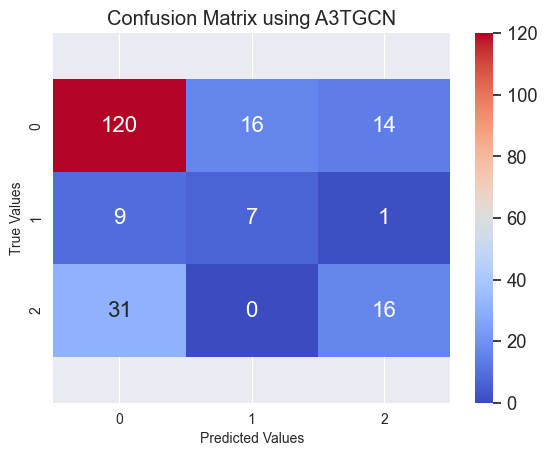

In [15]:
# Plot of the confusion matrix to a heatmap
df_cm = pd.DataFrame(confusion_matrix, range(3), range(3))
ax= plt.subplot()
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="coolwarm", annot=True, annot_kws={"size": 16}, fmt='d', ax = ax)
plt.title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_title('Confusion Matrix using EvolveGCNO')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

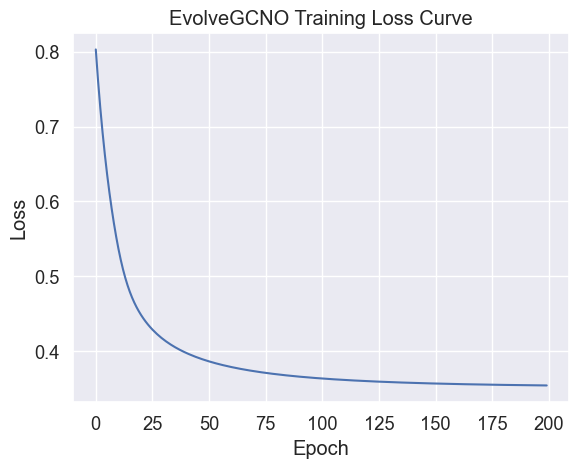

In [16]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EvolveGCNO Training Loss Curve')
plt.show()